In [1]:
%matplotlib inline

import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp

import itertools
import math

sns.set();

# Dormand-Prince Method

> Disclaimer: the original code (written in Scilab) and example below are due to Leonardo Guidi.

In [2]:
def dopri(x0, xf, y0, f, rtol, atol):
    r"""
    Dormand-Prince method for solving first-order ODE.
    
    This function implements the Dormand-Prince5(4) method
    with adaptive step through the estimation of the error
    tolerance (with norm sup) from the approximations of
    global error O(h**5) and O(h**4).
    
    It solves the following IVP:
    
    y'=f(x,y), x > x0,
    y(x0) = y0.
    
    The initial step is computed from the algorithm proposed in
    Hairer,E; Nørsett,S.P.; Wanner,G. "Solving Ordinary
    Differential Equations I. Nonstiff Problems" 2nd rev.ed. (1993),
    pg. 169.
    
    The estimatives for the computation of the step follow the ideas
    exposed in this very same reference in pages 167 and 168.
    
    Parameters
    ----------
    x0 : float
        The initial value for the independent variable.
    xf : float
        The final value for the independent variable.
    y0 : array_like
        1-D array of initial values for the dependente variable evaluated at `x_0`.
    f : callable
        The function that represents the first derivative of y with respect to x.
        It must accept two arguments: the point x at which it will be evaluated and
        the value of y at this point.
        
    Returns
    ------
    x : numpy.ndarray
        The point at which the function was evaluated.
    y : numpy.ndarray
        The approximation of the solution.
    hc : numpy.ndarray
        Steps used along the computations.
    rp : list
        Iterations where rejection of the step size occurred.
    """
    
    xi = x0
    yi = y0
    fac = 0.8
    facmax = 5
    facmin = 0.2
    
    a = np.zeros((7, 7))
    a[1, 0] = 1/5
    a[2, 0:2] = np.array([3/40, 9/40])
    a[3, 0:3] = np.array([44/45, -56/15, 32/9])
    a[4, 0:4] = np.array([19372/6561, -25360/2187, 64448/6561, -212/729])
    a[5, 0:5] = np.array([9017/3168, -355/33, 46732/5247, 49/176, -5103/18656])
    a[6, 0:6] = np.array([35/384, 0.0, 500/1113, 125/192, -2187/6784, 11/84])
    
    b = np.array([5179/57600, 0.0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40])
    
    c = np.array([0.0, 1/5, 3/10, 4/5, 8/9, 1.0, 1.0])

    i = 0
    r = 0
    
    x = []
    y = []
    hc = []
    rp = []
    
    done = False

    d0 = np.max(np.abs(y0))
    d1 = np.max(np.abs(f(x0, y0)))
    
    h0 = 1.0e-6 if np.min([d0, d1]) < 1.0e-5 else (0.01 * (d0/d1))
    
    d2 = np.max(np.abs(f(x0 + h0, y0 + h0 * f(x0, y0)) - f(x0, y0)))/h0
    
    h1 = np.max(1.0e-6, h0/1000) if np.max([d1, d2]) < 1.0e-15 else (0.01/np.max([d1, d2]))**(1/5)
    
    h = np.min([100 * h0, h1])
    
    while not done:
        k1 = f(xi, yi)
        k2 = f(xi + h * c[1], yi + h * (a[1, 0] * k1))
        k3 = f(xi + h * c[2], yi + h * (a[2, 0] * k1 + a[2, 1] * k2))
        k4 = f(xi + h * c[3], yi + h * (a[3, 0] * k1 + a[3, 1] * k2 + a[3, 2] * k3))
        k5 = f(xi + h * c[4], yi + h * (a[4, 0] * k1 + a[4, 1] * k2 + a[4, 2] * k3 + a[4, 3] * k4))
        k6 = f(xi + h * c[5], yi + h * (a[5, 0] * k1 + a[5, 1] * k2 + a[5, 2] * k3 + a[5, 3] * k4 + a[5, 4] * k5))
        
        y4 = yi + h * (a[6, 0] * k1 + a[6, 2] * k3 + a[6, 3] * k4 + a[6, 4] * k5 + a[6, 5] * k6)
        
        k7 = f(xi + h * c[6], y4)
        
        y5 = yi + h * (b[0] * k1 + b[2] * k3 + b[3] * k4 + b[4] * k5 + b[5] * k6 + b[6] * k7)
        
        sc = atol + np.max([np.abs(y5), np.abs(yi)]) * rtol
        err = np.max(np.abs(y5 - y4))/sc
        hnew = h * np.min([facmax, np.max([facmin, fac * (1/err)**(1/5)])])
        
        if err <= 1:
            if (xi + h) <= xf:
                i += 1 
                xi += h
                yi = y5
                x.append(xi)
                y.append(yi)
                hc.append(h)
                h = hnew
            else:
                h = xf - xi
                r += 1
                rp.append(i)
        else:
            h = hnew
            r += 1
            rp.append(i)

        done = xi >= xf
        
    return (np.array(x), np.array(y), np.array(hc), rp)

## Example 1

In [3]:
def F(t, z):
    return np.array([z[1], z[0]**(-13) - z[0]**(-7)])

t, sol, hi, rejp = dopri(0.0, 100.0, np.array([2.0, 0.0]), F, atol=1.0e-8, rtol=1.0e-8)

q = np.insert(sol[:, 0], 0, 2)
p = np.insert(sol[:, 1], 0, 0)

H = (1/2) * (p**2) + (1/12) * (q**(-12) - 2 * q**(-6))

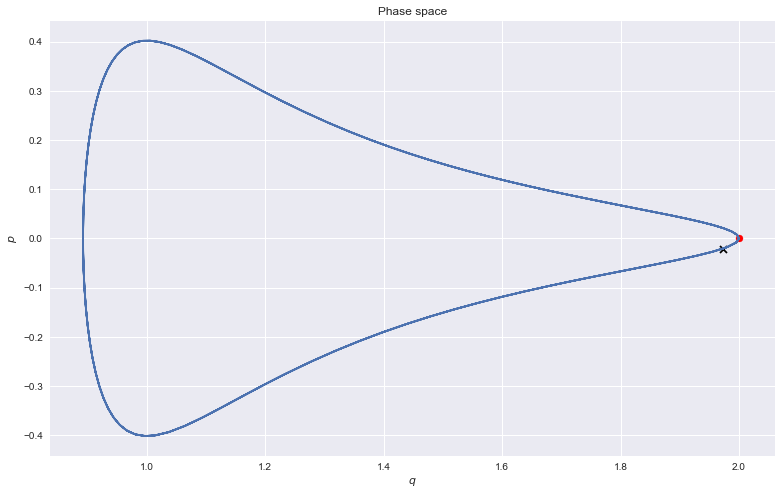

In [4]:
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot(q, p)
plt.scatter(q[0], p[0], marker='o', color='red')
plt.scatter(q[-1], p[-1], marker='x', color='black')
ax.set(title="Phase space", xlabel="$q$", ylabel="$p$");

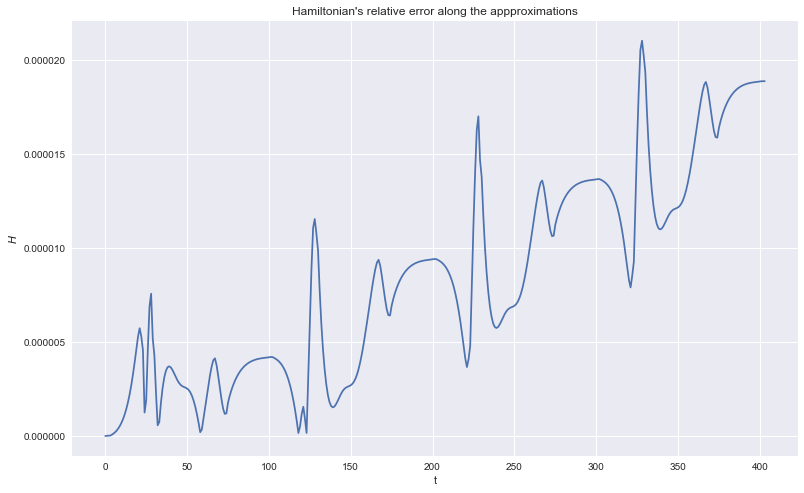

In [5]:
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot(np.abs(H/H[0] - 1))
ax.set(title="Hamiltonian's relative error along the appproximations", xlabel="t", ylabel="$H$");

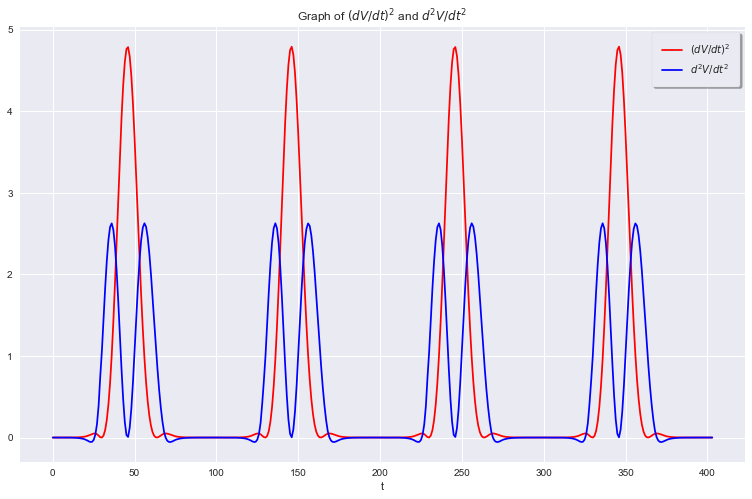

In [6]:
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot((q**-13 - q**-7)**2, label=r"$(dV/dt)^{2}$", color='red')
plt.plot((p**2) * (13 * q**-14 - 7 * q**-8), label=r"$d^{2}V/dt^{2}$", color='blue')
plt.legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1, frameon=True)
ax.set(title=r"Graph of $(dV/dt)^{2}$ and $d^{2}V/dt^{2}$", xlabel="t");

## Question 1

In [7]:
def F(t):
    return 1/2 + sum(5/n * math.sin(n*math.pi/10) * math.cos(n*math.sqrt(10)*t) for n in range(1, 6))


def f(t, u_k):
    return np.array([u_k[1], F(t) * math.cos(u_k[0]) - (1/10) * u_k[1] - 10 * math.sin(u_k[0])])


def mechanical_energy(theta, dtheta):
    return (1/2) * dtheta**2 - 10 * np.cos(theta)

t, sol, hi, rejp = dopri(0.0, 20.0, np.array([0.0, 0.0]), f, atol=1.0e-10, rtol=1.0e-10)
theta = sol[:, 0]
dtheta = sol[:, 1]

energy = mechanical_energy(theta, dtheta)

max_energy_index = np.argmax(energy)
t_max_energy = t[np.argmax(energy)]
max_energy = energy[np.argmax(energy)]


print("Mechanical energy in t = {:.4} is {:.4} J.".format(t_max_energy, max_energy))

Mechanical energy in t = 6.145 is -0.7452 J.


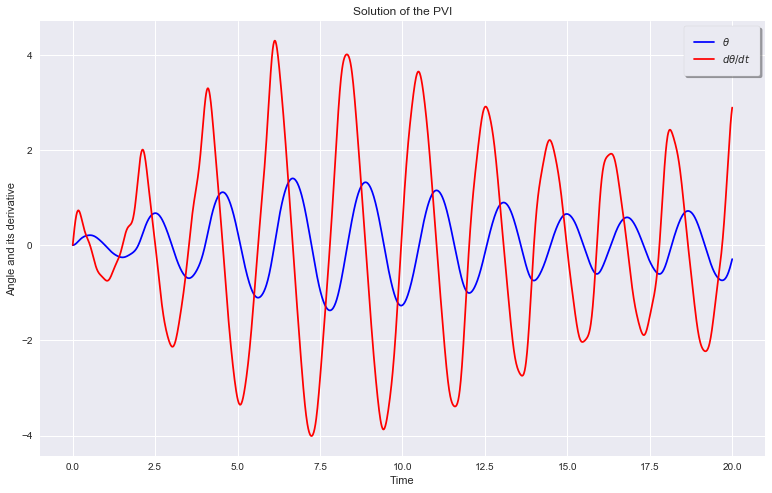

In [8]:
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot(t, theta, color='blue', label=r"$\theta$")
plt.plot(t, dtheta, color='red', label=r"$d\theta/dt$")
plt.legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1, frameon=True)
ax.set(title="Solution of the PVI", xlabel="Time", ylabel="Angle and its derivative");

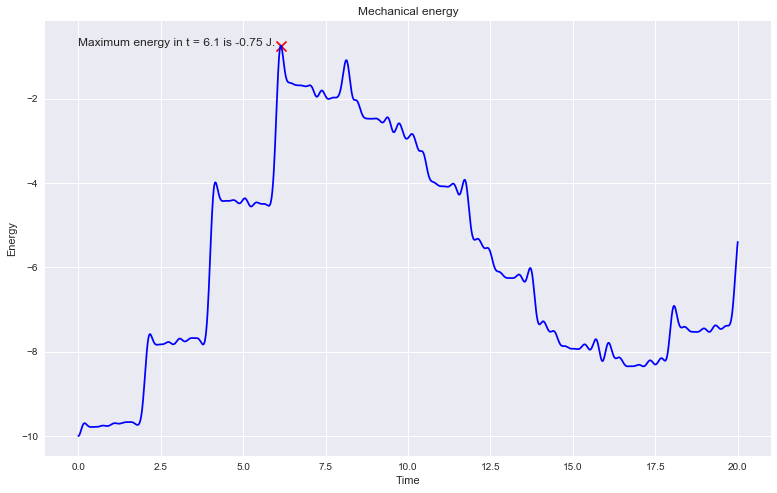

In [9]:
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot(t, energy, color='blue')
plt.scatter(t_max_energy, max_energy, color='red', marker='x', s=100)
plt.text(0.0, max_energy, "Maximum energy in t = {:.2} is {:.2} J.".format(t_max_energy, max_energy))
ax.set(title="Mechanical energy", xlabel="Time", ylabel="Energy");